In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read Images

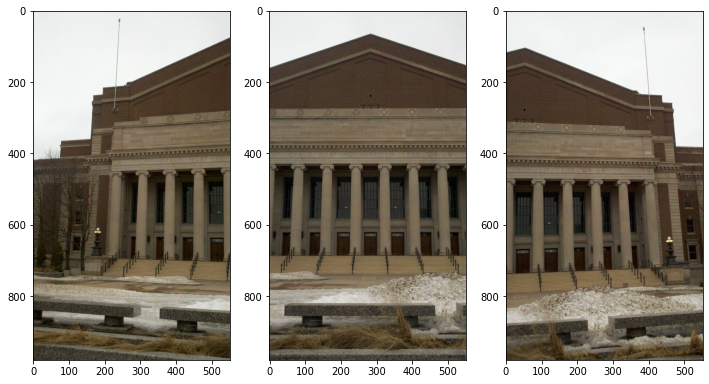

In [2]:
from matplotlib import rcParams

# figure size in inches optional
rcParams['figure.figsize'] = 12 ,8

# read images
img1 = cv2.imread("Images/mall1.jpg")
img2 = cv2.imread("Images/mall2.jpg")
img3 = cv2.imread("Images/mall3.jpg")

left = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
mid = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
right = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

# display images
fig, ax = plt.subplots(1,3)
ax[0].imshow(left)
ax[1].imshow(mid)
ax[2].imshow(right)

## Stiching image 2 and 3

### Detecting Descriptors

In [3]:
# create sift object
sift = cv2.SIFT_create()

Since we only need to find descriptors on the right side for image 1 and left side for image 3, we will create masks.

In [4]:
# get descriptors
kp_mid, desc_mid = sift.detectAndCompute(mid, None)
kp_right, desc_right = sift.detectAndCompute(right, None)

### Match Descriptors

In [5]:
bf = cv2.BFMatcher()
matches_mid_right = bf.knnMatch(desc_right, desc_mid, k = 2)

In [6]:
# use only good matches to save computation tim
filtered_matches = []
for m in matches_mid_right:
    if m[0].distance < 0.5*m[1].distance:
        filtered_matches.append(m)
        
matches_mid_right = np.asarray(filtered_matches)

### Find Homography Matrix

In [7]:
# find index locations corresponding to descriptors
src_pts = np.float32([ kp_right[a.queryIdx].pt for a in matches_mid_right[:,0]]).reshape(-1,1,2)
dst_pts = np.float32([ kp_mid[a.trainIdx].pt for a in matches_mid_right[:,0]]).reshape(-1,1,2)

In [8]:
h_mid_right, status23 = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

In [9]:
print(h_mid_right)

[[ 9.02749545e-01  1.81116928e-02  2.31302911e+02]
 [-8.79204968e-02  9.89074871e-01 -3.21812960e+01]
 [-1.85260154e-04  2.07060623e-05  1.00000000e+00]]


In [10]:
# transform right image
src_trans = cv2.warpPerspective(right, h_mid_right, (mid.shape[1] + int(right.shape[1]/2), mid.shape[0]))

Text(0.5, 1.0, 'right image')

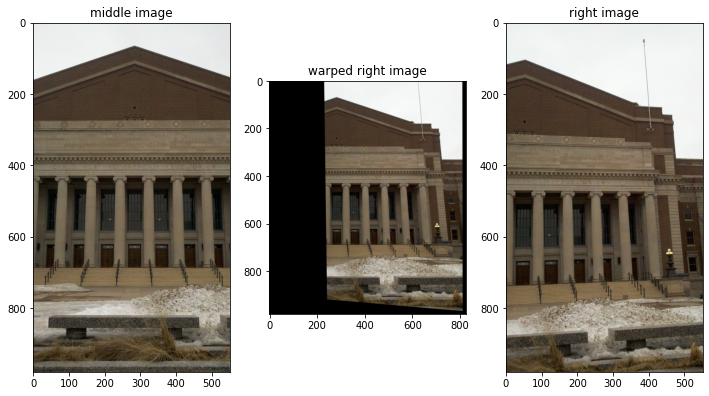

In [11]:
plt.subplot(1, 3, 1)
plt.imshow(mid)
plt.title('middle image')

plt.subplot(1, 3, 2)
plt.imshow(src_trans)
plt.title('warped right image')

plt.subplot(1, 3, 3)
plt.imshow(right)
plt.title('right image')

### Stitch middle image with warped right

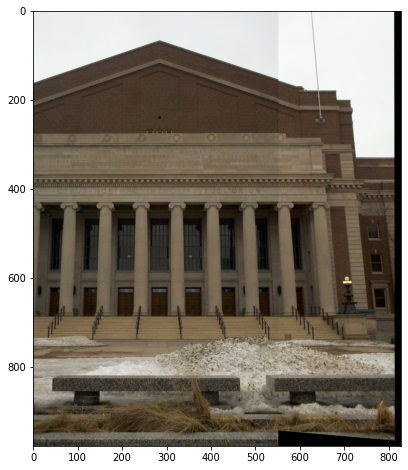

In [12]:
src_trans[:, 0:mid.shape[1], :] = mid
plt.imshow(src_trans)

## Stitching image 1 with 2+3

In [13]:
# set newly stiched image as right image
right = src_trans

In [14]:
# get descriptors
kp_left, desc_left = sift.detectAndCompute(left, None)
kp_right, desc_right = sift.detectAndCompute(right, None)

### Match Descriptors

In [15]:
bf = cv2.BFMatcher()
matches_left_right = bf.knnMatch(desc_right, desc_left, k = 2)

In [16]:
# use only good matches to save computation tim
filtered_matches = []
for m in matches_left_right:
    if m[0].distance < 0.5*m[1].distance:
        filtered_matches.append(m)
        
matches_left_right = np.asarray(filtered_matches)

### Find Homography Matrix

In [17]:
# find index locations corresponding to descriptors
src_pts = np.float32([ kp_right[a.queryIdx].pt for a in matches_left_right[:,0]]).reshape(-1,1,2)
dst_pts = np.float32([ kp_left[a.trainIdx].pt for a in matches_left_right[:,0]]).reshape(-1,1,2)

In [18]:
h_left_right, status123 = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

In [19]:
# transform left image
src_trans = cv2.warpPerspective(right, h_left_right, (right.shape[1] + left.shape[1], left.shape[0]))

Text(0.5, 1.0, 'right image')

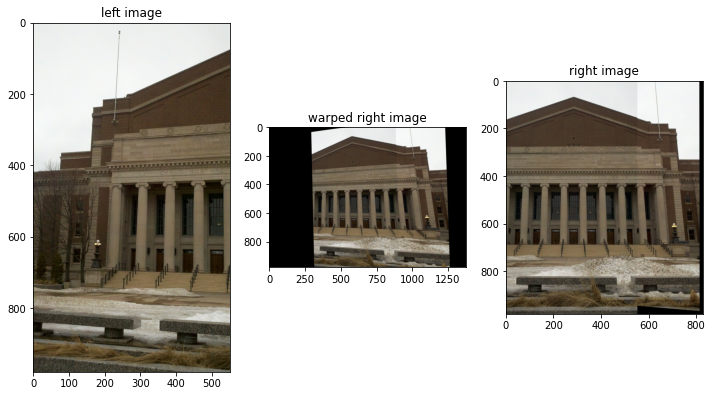

In [20]:
plt.subplot(1, 3, 1)
plt.imshow(left)
plt.title('left image')

plt.subplot(1, 3, 2)
plt.imshow(src_trans)
plt.title('warped right image')

plt.subplot(1, 3, 3)
plt.imshow(right)
plt.title('right image')

# Panorama Image

### Stitch left image with warped right image

Text(0.5, 1.0, 'Final Panorama Image')

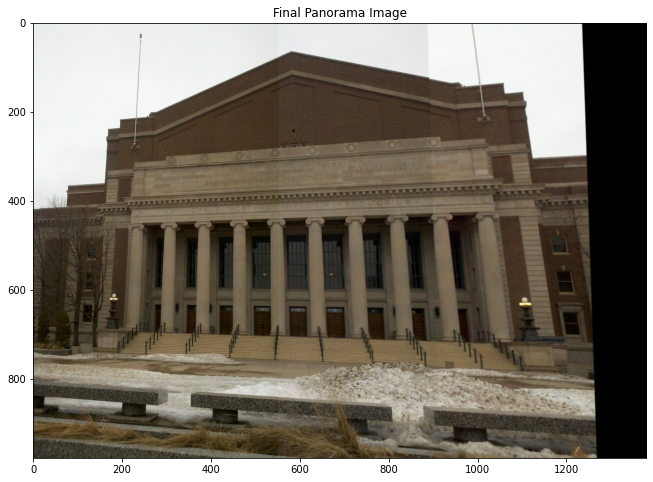

In [21]:
src_trans[:, 0:left.shape[1], :] = left
plt.imshow(src_trans)
plt.title('Final Panorama Image')